In [1]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/2025-espectro-banano/')
import os
import pandas as pd
import dataFunction3 as datF
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!ls /content/drive/

MyDrive  Shareddrives


In [5]:
file = 'newdatos_Junio14_dataset.csv'
path = r"/content/drive/MyDrive/2025-espectro-banano/"
file = os.path.join(path, file)
df = pd.read_csv(file, sep=';')

In [6]:
#Revisión de columnas del dataframe
df.columns

Index(['dpi', 'Sana', 'Tratamiento', '350', '351', '352', '353', '354', '355',
       '356',
       ...
       '2491', '2492', '2493', '2494', '2495', '2496', '2497', '2498', '2499',
       '2500'],
      dtype='object', length=2154)

1 -> Control
0 -> Enfermas (todas)
-1 -> Estrés Hídrico

In [7]:
#Valores de cada clase en la variable "Sana"
df.Sana.value_counts()

,count
Sana,
0,2452
1,637
-1,448


In [8]:
#Verificación de cantidad de muestras en la variable de salida (Sana) dentro de cada tratamiento
df.Tratamiento.value_counts()

,count
Tratamiento,
E_Hidrico,478
Control,461
Fusarium,448
Fus_EH_Ral,442
Ral_EH,436
Fus_EH,432
Ralstonia,428
Ral_Fus,412


In [9]:

pd.crosstab(df.Sana, df.Tratamiento)
df.dpi.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

/tmp/ipython-input-10-1663362011.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[spectral_cols] = df[[str(col) for col in spectral_cols]].apply(pd.to_numeric)
/tmp/ipython-input-10-1663362011.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[spectral_cols] = df[[str(col) for col in spectral_cols]].apply(pd.to_numeric)
/tmp/ipython-input-10-1663362011.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

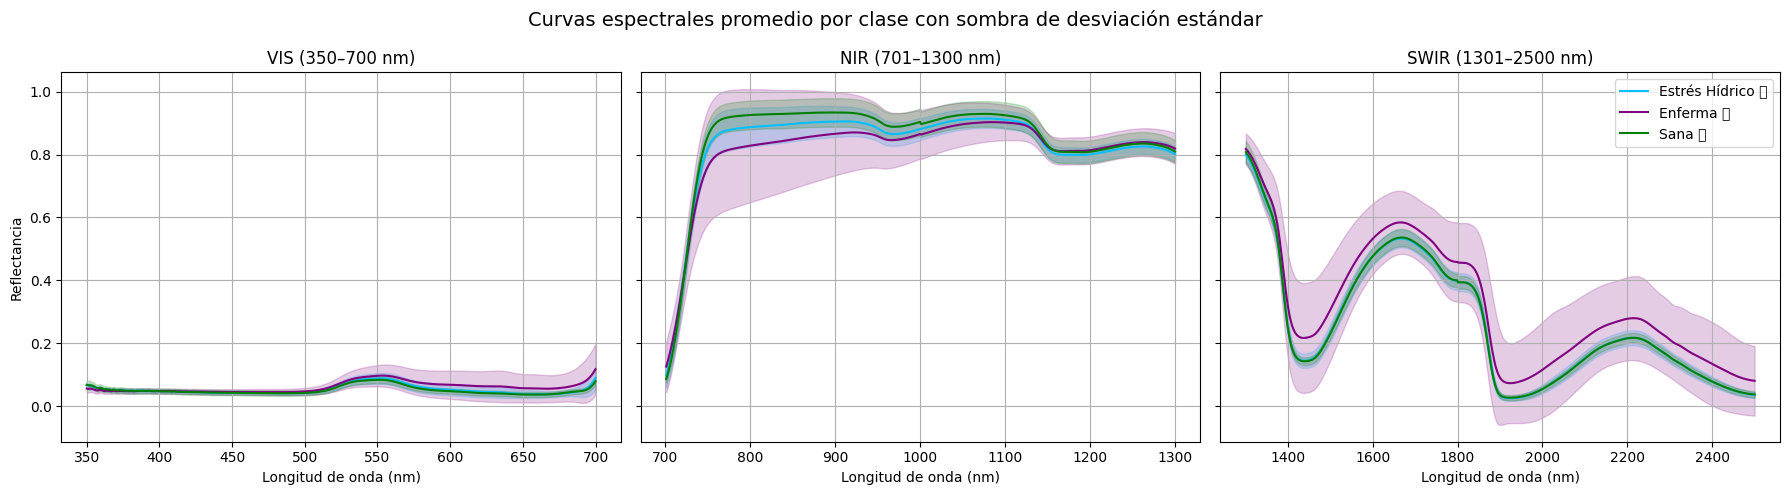

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir nombres de columnas espectrales a enteros (por si acaso son strings)
spectral_cols = list(map(int, range(350, 2501)))  # desde 350 hasta 2500
df[spectral_cols] = df[[str(col) for col in spectral_cols]].apply(pd.to_numeric)

# Crear diccionario de clases
class_map = {
    1: 'Sana 🌿',
    0: 'Enferma 🍄',
    -1: 'Estrés Hídrico 💧'
}
colors = {
    1: 'green',
    0: 'purple',
    -1: 'deepskyblue'
}

# Dividir en tramos
tramos = {
    "VIS (350–700 nm)": list(range(350, 701)),
    "NIR (701–1300 nm)": list(range(701, 1301)),
    "SWIR (1301–2500 nm)": list(range(1301, 2501))
}

# Crear la figura
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (titulo, rango) in zip(axes, tramos.items()):
    for clase in [-1, 0, 1]:
        datos_clase = df[df['Sana'] == clase][rango]
        media = datos_clase.mean()
        std = datos_clase.std()

        ax.plot(rango, media, label=class_map[clase], color=colors[clase])
        ax.fill_between(rango, media - std, media + std, alpha=0.2, color=colors[clase])

    ax.set_title(titulo)
    ax.set_xlabel("Longitud de onda (nm)")
    ax.grid(True)

axes[0].set_ylabel("Reflectancia")
axes[2].legend()
fig.suptitle("Curvas espectrales promedio por clase con sombra de desviación estándar", fontsize=14)
plt.tight_layout()
plt.show()


In [11]:
df['Sana'] = df['Sana'].replace(-1,1)
df.Sana.unique()

array([1, 0])

In [12]:
df.Sana.value_counts()

,count
Sana,
0,2452
1,1085


In [13]:
# Creamos las variables dummy a partir de la columna 'Tratamiento'
# El parámetro drop_first=True evita la multicolinealidad eliminando una categoría
#df_dummies = pd.get_dummies(df['Tratamiento'], prefix='Tratamiento', drop_first=True)

# Unimos esas columnas nuevas al dataframe original (¡sin sobrescribirlo aún!)
#df_encoded = pd.concat([df.drop(columns=['Tratamiento']), df_dummies], axis=1)


In [14]:
# Crear variables dummy para 'Tratamiento' (¡sin multicolinealidad!)
df_dummies = pd.get_dummies(df['Tratamiento'], prefix='Tratamiento', drop_first=True)

# Unimos las columnas dummy al dataframe original y eliminamos la original
df_encoded = pd.concat([df.drop(columns=['Tratamiento', 'dpi']), df_dummies], axis=1)

# Definir variables X (features) e y (target)
X = df_encoded.drop(columns='Sana')
y = df_encoded['Sana']

In [15]:
#Visualización de todas las columnas del dataframe
pd.options.display.max_columns = None
X

350       351       352       353       354       355       356  \
0     0.061030  0.060394  0.053344  0.054736  0.057163  0.055928  0.049880   
1     0.060823  0.060909  0.056016  0.056755  0.057975  0.056499  0.051715   
2     0.059742  0.060113  0.057320  0.059280  0.059741  0.057078  0.053557   
3     0.048861  0.047099  0.044486  0.049340  0.052701  0.050598  0.044007   
4     0.063155  0.060788  0.057388  0.058424  0.060128  0.059009  0.053017   
...        ...       ...       ...       ...       ...       ...       ...   
3532  0.043432  0.040299  0.044928  0.043590  0.043106  0.043309  0.039035   
3533  0.060325  0.058118  0.063626  0.059556  0.056792  0.055577  0.048689   
3534  0.062275  0.062429  0.065365  0.062081  0.061105  0.061609  0.056559   
3535  0.062731  0.059813  0.065723  0.062644  0.058222  0.055873  0.054696   
3536  0.052329  0.051554  0.060262  0.055158  0.051641  0.052838  0.051697   

           357       358       359       360       361       362       363  \
0     0.043096  0.041127  0.044614  0.047290  0.044314  0.040524  0.040864   
1     0.047413  0.045700  0.046623  0.047977  0.045781  0.043576  0.044460   
2     0.049205  0.047486  0.048903  0.048999  0.048933  0.048858  0.048577   
3     0.038449  0.036496  0.038123  0.040778  0.038815  0.035631  0.035387   
4     0.048921  0.047316  0.048053  0.051889  0.050260  0.046879  0.046703   
...        ...       ...       ...       ...       ...       ...       ...   
3532  0.036975  0.040105  0.044996  0.039308  0.036374  0.037082  0.038483   
3533  0.050063  0.054036  0.055316  0.053593  0.049511  0.047189  0.048789   
3534  0.058367  0.062300  0.063542  0.060880  0.057886  0.057248  0.059117   
3535  0.053367  0.053773  0.055217  0.052329  0.049764  0.048775  0.049265   
3536  0.050770  0.051495  0.053225  0.052534  0.048990  0.047055  0.049422   

           364       365       366       367       368       369       370  \
0     0.040998  0.040610  0.039461  0.037711  0.038616  0.038423  0.036420   
1     0.042654  0.041755  0.041794  0.040874  0.039933  0.039017  0.038256   
2     0.047249  0.045801  0.045322  0.046451  0.046223  0.045126  0.043726   
3     0.035967  0.034903  0.032986  0.032659  0.034071  0.033916  0.031631   
4     0.047087  0.045839  0.044143  0.044565  0.044463  0.044129  0.043632   
...        ...       ...       ...       ...       ...       ...       ...   
3532  0.036807  0.036659  0.037748  0.037225  0.036608  0.037046  0.037944   
3533  0.047448  0.045809  0.045638  0.047533  0.048396  0.047662  0.046309   
3534  0.056402  0.056543  0.058239  0.056099  0.056491  0.057204  0.056949   
3535  0.050473  0.049483  0.047245  0.046744  0.048354  0.048378  0.046414   
3536  0.048609  0.048539  0.049042  0.048019  0.049270  0.049621  0.048270   

           371       372       373       374       375       376       377  \
0     0.036617  0.037034  0.037033  0.036325  0.034392  0.034549  0.035668   
1     0.037969  0.039536  0.040762  0.039857  0.038471  0.037217  0.036446   
2     0.042114  0.042501  0.043219  0.042527  0.040967  0.041026  0.041563   
3     0.030428  0.031365  0.032633  0.032369  0.030487  0.029426  0.029142   
4     0.042288  0.043951  0.045402  0.043786  0.041943  0.041269  0.041320   
...        ...       ...       ...       ...       ...       ...       ...   
3532  0.036504  0.038476  0.039486  0.036594  0.038439  0.037718  0.036049   
3533  0.046786  0.048559  0.049546  0.048591  0.048327  0.046833  0.045715   
3534  0.056776  0.057233  0.057553  0.057435  0.059222  0.058867  0.057911   
3535  0.046736  0.047527  0.047510  0.046545  0.047659  0.047325  0.046365   
3536  0.048323  0.049033  0.049999  0.050809  0.051020  0.050063  0.049467   

           378       379       380       381       382       383       384  \
0     0.034886  0.034981  0.035452  0.035519  0.034462  0.034833  0.035569   
1     0.036258  0.036215  0.037086  0.038096  0.036567  0.037052  0.038161   
2     0.040176  0.040118  0.0

In [16]:
#Cambiar etiquetas de variables predictoras a string
#X.columns = X.columns.astype(str)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# División estratificada para respetar proporciones de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Cambiar etiquetas de variables predictoras a string luego de haber realizado la división de los datos
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Estandarización (aunque algunos modelos no lo necesitan, nos sirve para posibles comparaciones)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Diccionario para guardar todos los resultados
resultados_modelos = {}

def entrenar_y_evaluar(modelo, nombre_modelo):
    # Creamos el pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('modelo', modelo)
    ])

    # Entrenamos
    pipe.fit(X_train, y_train)

    # Predecimos
    y_pred = pipe.predict(X_test)

    # Reporte textual
    print(f"📌 Resultados para {nombre_modelo}")
    print(classification_report(y_test, y_pred))

    # Guardar métricas en tabla
    reporte = classification_report(y_test, y_pred, output_dict=True)
    resultados_modelos[nombre_modelo] = {
        'accuracy': reporte['accuracy'],
        'precision_0': reporte['0']['precision'],
        'recall_0': reporte['0']['recall'],
        'f1_0': reporte['0']['f1-score'],
        'precision_1': reporte['1']['precision'],
        'recall_1': reporte['1']['recall'],
        'f1_1': reporte['1']['f1-score'],
        'macro_f1': reporte['macro avg']['f1-score']
    }

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Enferma','Sana'], yticklabels=['Enferma','Sana'])
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

In [19]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


📌 Resultados para Random Forest
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       491
           1       0.92      0.74      0.82       217

    accuracy                           0.90       708
   macro avg       0.91      0.86      0.88       708
weighted avg       0.90      0.90      0.90       708



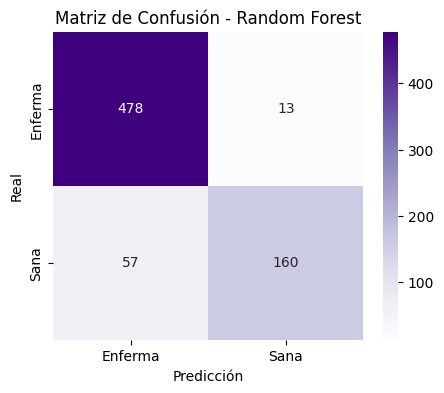

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:04:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 Resultados para XGBoost
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       491
           1       1.00      0.94      0.97       217

    accuracy                           0.98       708
   macro avg       0.98      0.97      0.98       708
weighted avg       0.98      0.98      0.98       708



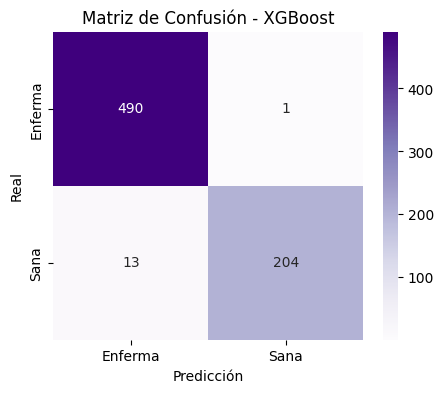

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 868, number of negative: 1961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.512516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1097031
[LightGBM] [Info] Number of data points in the train set: 2829, number of used features: 4309
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306822 -> initscore=-0.815018
[LightGBM] [Info] Start training from score -0.815018
📌 Resultados para LightGBM
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       491
           1       1.00      0.94      0.96       217

    accuracy                           0.98       708
   macro avg       0.98      0.97      0.97       708
weighted avg       0.98      0.98      0.98       708



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


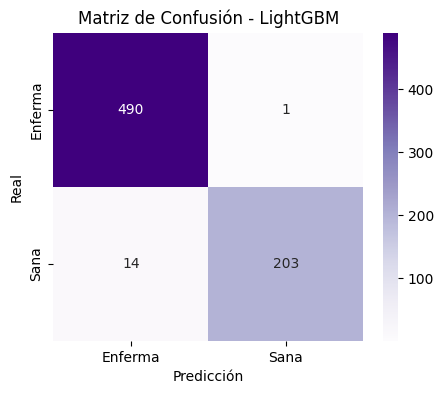

📌 Resultados para CatBoost
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       491
           1       1.00      0.95      0.97       217

    accuracy                           0.98       708
   macro avg       0.99      0.97      0.98       708
weighted avg       0.98      0.98      0.98       708



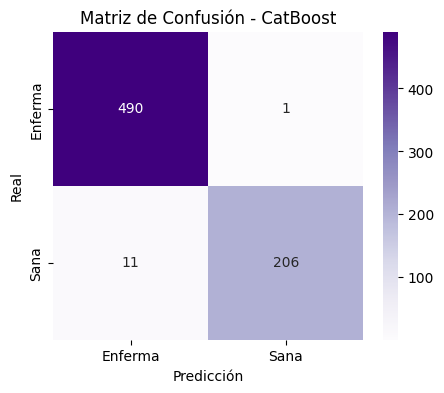

In [20]:
# Ajustamos los modelos
# Modelos a importar
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Random Forest con ajuste de desbalanceo
entrenar_y_evaluar(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    "Random Forest"
)

# XGBoost (usa scale_pos_weight = ratio entre clases mayoritarias/minoritarias)
entrenar_y_evaluar(
    XGBClassifier(scale_pos_weight=2452/1085, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "XGBoost"
)

# LightGBM
entrenar_y_evaluar(
    LGBMClassifier(is_unbalance=True, random_state=42),
    "LightGBM"
)

# CatBoost
entrenar_y_evaluar(
    CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42),
    "CatBoost"
)

Tras entrenar y evaluar cuatro modelos (Random Forest, LightGBM, XGBoost y CatBoost), los resultados mostraron que:

**CatBoost fue el mejor modelo,** alcanzando un **accuracy del 98.3%** y un **f1-score promedio (macro_f1) de 0.980**, lo que indica un equilibrio excelente entre precisión y recuperación en ambas clases.

**XGBoost** y **LightGBM** también mostraron rendimientos sobresalientes con macro **F1-scores de 0.976 y 0.975,** respectivamente.

**Random Forest,** aunque cumplió su papel, obtuvo métricas significativamente más bajas, especialmente en el reconocimiento de la clase sana (f1_1 = 0.821).

Esto sugiere que los modelos de boosting (especialmente CatBoost) manejan mucho mejor la complejidad del conjunto de datos, incluso frente al leve desbalance de clases.

In [21]:
#Visualización de los resultados obtenidos de cada modelo
# Convertimos el diccionario en DataFrame
df_resultados = pd.DataFrame(resultados_modelos).T

# Redondeamos para que se vea más limpio
df_resultados = df_resultados.round(3)

# Ordenamos por el f1-score promedio (macro_f1)
df_resultados.sort_values(by='macro_f1', ascending=False, inplace=True)

# Mostramos la tabla
df_resultados


,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,macro_f1
CatBoost,0.983,0.978,0.998,0.988,0.995,0.949,0.972,0.980
XGBoost,0.980,0.974,0.998,0.986,0.995,0.940,0.967,0.976
LightGBM,0.979,0.972,0.998,0.985,0.995,0.935,0.964,0.975
Random Forest,0.901,0.893,0.974,0.932,0.925,0.737,0.821,0.876


Se escoge la visualización de la métrica Macro F1 en el barplot dado que compara el desempeño entre clases incluso si están desbalanceadas como en este caso y le damos la misma importancia a cada clase por igual.

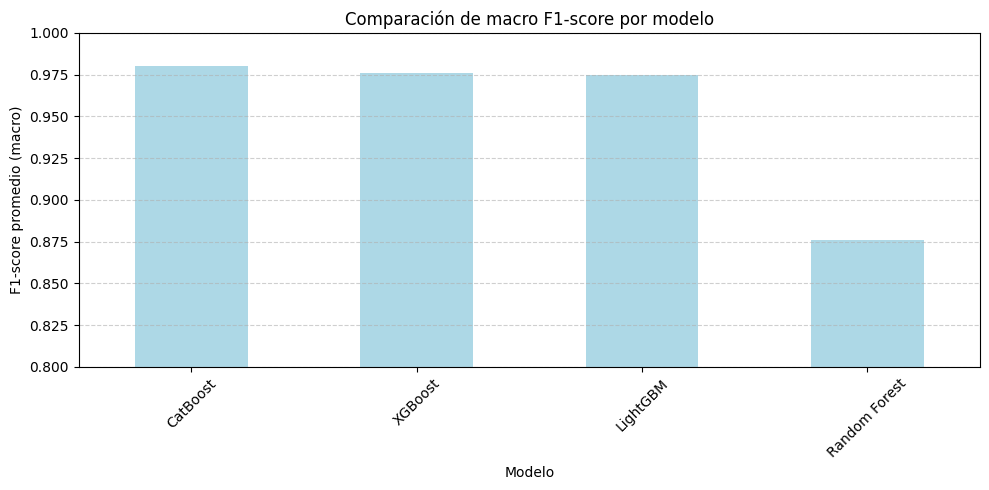

In [22]:
import matplotlib.pyplot as plt

# Barplot comparativo de los modelos por macro_f1
df_resultados[['macro_f1']].plot(kind='bar', figsize=(10, 5), legend=False, color='lightblue')
plt.title("Comparación de macro F1-score por modelo")
plt.ylabel("F1-score promedio (macro)")
plt.xlabel("Modelo")
plt.ylim(0.8, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#**¡¡A partir de aquí queremos trabajar con modelos de árboles de decisión con múltiples salidas.... Este código queda incompleto para continuar en un futuro**!!

Una **clasificación en dos etapas:**

**Primera etapa** (lo que ya tenemos con CatBoost):

Clasifica si la planta está **sana (1)** o **enferma (0).**

**Segunda etapa** (si se predice como "enferma"):

Se activa otro modelo que recibe **solo los datos predichos como enfermos** y los clasifica en **la enfermedad específica:** Fusarium, Ralstonia, Estrés Hídrico, etc.

Esto tiene sentido porque permite especializar modelos:

Uno para decidir si hay enfermedad.

* Otro para identificar **cuál enfermedad.**

* Mejora el **rendimiento y la interpretabilidad.**

Lo que queremos saber propiamente es:

**Primero:** ¿la planta está bien?

**Luego:** ¿si está mal, qué tiene?

**Paso 1:** **Filtramos los datos con plantas enfermas** (según y == 0)
Aquí vamos a tomar solo los datos originales (no test/train todavía) que se etiquetaron como enfermos (es decir, y == 0) y vamos a preparar ese subconjunto con su propia X y su y.

In [23]:
# Creamos un índice con las plantas enfermas según y == 0
idx_enfermas = y[y == 0].index

# Filtramos solo las filas del dataframe original con ese índice
df_enfermas = df.loc[idx_enfermas].copy()

# Features: longitudes de onda + tratamiento
columnas_espectrales = [col for col in df_enfermas.columns if col.isdigit()]
X_enfermas = df_enfermas[columnas_espectrales]
y_enfermas = df_enfermas["Tratamiento"]  # ¡Aquí está tu variable multiclase!


AttributeError: 'int' object has no attribute 'isdigit'

In [ ]:
# Paso 1: Seleccionar las columnas espectrales
longitudes_onda = [col for col in df.columns if col.isdigit()]
df_espectro = df[longitudes_onda]

# Visualizar solo las primeras 50 columnas
corr_subset = df_espectro.iloc[:, :50].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, cmap='coolwarm', center=0, annot=False)
plt.title("Matriz de correlación de las primeras 50 longitudes de onda")
plt.show()


**Aplicación de la correlación de Pearson**

Para analizar la redundancia y la dependencia entre las longitudes de onda espectrales, utilizamos la matriz de correlación de Pearson. Este tipo de correlación mide la fuerza y dirección de las relaciones lineales entre variables numéricas, lo cual resulta apropiado en este contexto, ya que los datos espectrales suelen presentar variaciones suaves y continuas a lo largo del espectro. Pearson permite identificar qué bandas están altamente correlacionadas entre sí, lo cual nos guía hacia una posible reducción de la dimensionalidad (por ejemplo, mediante PCA), al eliminar la información redundante. Además, su interpretación es directa y ampliamente aceptada en análisis exploratorios de datos multivariados.

In [ ]:
# Calcular la matriz de correlación completa
corr_matrix = df_espectro.corr().abs()

# Excluir la diagonal (autocorrelación)
mean_corr = (corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]).mean()
print(f"Promedio de correlación entre columnas espectrales: {mean_corr:.4f}")


In [ ]:
# Extraer todas las correlaciones superiores a la diagonal
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_values = upper_triangle.stack()

plt.figure(figsize=(10, 5))
sns.histplot(corr_values, bins=50, kde=True)
plt.title("Distribución de correlaciones entre longitudes de onda")
plt.xlabel("Correlación absoluta")
plt.ylabel("Frecuencia")
plt.show()


Decidimos aplicar PCA **(Análisis de Componentes Principales)** como una técnica de reducción de dimensionalidad debido a la alta correlación entre las longitudes de onda. Como se evidencia en los histogramas y la matriz de correlación, múltiples bandas espectrales están fuertemente correlacionadas (promedio ≈ 0.66). Esto indica redundancia de información, que puede afectar negativamente el rendimiento del modelo y aumentar el tiempo de cómputo. PCA nos permite conservar la mayor parte de la varianza explicada por los datos originales, utilizando menos variables, lo cual es ideal para evitar el sobreajuste y mejorar la eficiencia computacional.

### **Selección de variables predictoras (X)**

En esta sección combinamos dos tipos de información como entrada (features) para nuestro modelo:

1. **Datos espectrales:** columnas numéricas que representan las longitudes de onda desde 350 nm hasta 2500 nm. Estas contienen señales del comportamiento fisiológico de las plantas.

2. **Tratamiento aplicado:** información sobre el tratamiento que recibió cada planta (por ejemplo, control, estrés hídrico, fusarium, etc.), codificada mediante variables dummy (0 y 1) para que el modelo pueda procesarlas fácilmente.

Al combinar estos dos conjuntos de datos, le damos al modelo una visión más completa para clasificar si una planta está sana o no.


In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler
#Estandarizo solo con X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # ¡Solo se hace .fit aquí!
X_test_scaled = scaler.transform(X_test)        # Aquí solo se transforma

Como ya dividimos los datos en entrenamiento y prueba, seguimos las buenas prácticas de modelado:

1. Aplicamos .fit únicamente sobre los datos de entrenamiento escalados (X_train_scaled). Esto ajusta el modelo PCA solo con información del entrenamiento, evitando contaminación (data leakage).

2. Usamos .transform en los datos de prueba escalados (X_test_scaled) para proyectarlos al mismo espacio aprendido.

3. Además, en este paso elegimos la cantidad de componentes necesarias para conservar el 95% de la varianza total, lo que nos garantiza que seguimos trabajando con casi toda la información, pero con muchas menos variables.

4. Este proceso permite trabajar de forma más eficiente con algoritmos de clasificación, al tiempo que mitigamos la redundancia y la multicolinealidad entre las más de 2000 longitudes de onda originales.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Por ejemplo, conservar el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


En este paso entrenamos un modelo de clasificación *(Random Forest)* utilizando las componentes principales del conjunto de entrenamiento (X_train_pca). Al usar los datos transformados por PCA, mejoramos la eficiencia del modelo y reducimos el riesgo de sobreajuste. 🌱🌳



In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

En este paso, usamos el conjunto de prueba (X_test_pca) para predecir las etiquetas y comparar con las verdaderas (y_test). El classification_report nos da métricas clave como precisión, recall y F1-score, que nos ayudan a evaluar el desempeño del modelo de forma completa. 📊🌿

Clase 0 (posiblemente plantas enfermas):

Precision: 0.93 → el 93% de las veces que predijo "enferma", acertó.

Recall: 1.00 → no dejó escapar ninguna muestra enferma. ¡Bravo!

F1-score: 0.96 → muy buen equilibrio entre precision y recall.

Clase 1 (posiblemente plantas sanas):

Precision: 1.00 → todas las predicciones de "sana" fueron correctas.

Recall: 0.64 → aquí está el detalle: solo capturó el 64% de las plantas sanas reales.

F1-score: 0.78 → un poco más bajito porque hay un desequilibrio.

In [ ]:
# Prueba del modelo
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))


Ahora, queremos probar qué tan bien funcionan distintos algoritmos de clasificación sobre datos desbalanceados, sin hacer balanceo externo, usando solo sus configuraciones para ajustar el peso de las clases.

Los modelos que vamos a probar son:

| Modelo           | Parámetro usado para compensar desbalance  |
| ---------------- | ------------------------------------------ |
| **XGBoost**      | `scale_pos_weight`                         |
| **LightGBM**     | `is_unbalance=True` *o* `scale_pos_weight` |
| **RandomForest** | `class_weight='balanced'`                  |
| **CatBoost**     | `auto_class_weights='Balanced'`            |


In [ ]:
#Modelo XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Calcular la proporción entre clases
# Aquí el truco es: total de clase 0 / total de clase 1
peso = y_train.value_counts()[0] / y_train.value_counts()[1]

# Entrenar modelo con peso ajustado
xgb_clf = XGBClassifier(scale_pos_weight=peso, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_pca, y_train)

# Predecir y evaluar
y_pred_xgb = xgb_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred_xgb))



In [ ]:
!pip install lightgbm

In [ ]:
# Modelo LightGBM
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Crear el modelo con el parámetro para datos desbalanceados
lgbm_clf = LGBMClassifier(is_unbalance=True, random_state=42)

# Entrenar con los datos reducidos con PCA
lgbm_clf.fit(X_train_pca, y_train)

# Predecir
y_pred_lgbm = lgbm_clf.predict(X_test_pca)

# Evaluar
print(classification_report(y_test, y_pred_lgbm))


In [ ]:
# Modelo CatBoost
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

# Entrenar el modelo con pesos automáticos (¡ideal para datos desbalanceados!)
cat_clf = CatBoostClassifier(verbose=0,               # para que no imprima todo en consola
                             random_state=42,
                             auto_class_weights='Balanced')

cat_clf.fit(X_train_pca, y_train)

# Predecir y evaluar
y_pred_cat = cat_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred_cat))


In [ ]:
#La aplicación de este PCA tiene fines de análisis exploratorio (como hacer el scree plot, biplots, o analizar la varianza acumulada).
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Estándarizar las longitudes de onda (importantísimo antes del PCA)
scaler = StandardScaler()
X_espectro_scaled = scaler.fit_transform(df[longitudes_onda])

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_espectro_scaled)

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = varianza_explicada.cumsum()

# Gráfico de scree (summary)
plt.figure(figsize=(10,5))
plt.plot(range(1, len(varianza_explicada)+1), varianza_acumulada, marker='o')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()



Utilizamos un análisis de componentes principales (PCA) para explorar la redundancia entre las más de 2000 longitudes de onda. El gráfico de varianza explicada acumulada nos permitió identificar cuántas componentes principales eran necesarias para retener una proporción significativa de la información original. Además, construimos un **biplot** con las dos primeras componentes para visualizar la separación entre plantas sanas y no sanas, lo cual apoya la idea de que estas variables capturan patrones útiles para la clasificación.

In [ ]:
# Crear un DataFrame con las dos primeras componentes
df_pca = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])

# Agregar la variable de color (por ejemplo, Sana)
df_pca['Sana'] = df['Sana'].values

# Biplot con seaborn
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Sana', palette='Set1', alpha=0.7)
plt.title('Biplot de las dos primeras componentes principales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.1f}% varianza)')
plt.grid(True)
plt.legend(title='Sana')
plt.show()

El biplot presenta la distribución de las muestras según las dos primeras componentes principales obtenidas mediante PCA. Estas componentes explican más del 87% de la varianza total del conjunto espectral, lo que permite visualizar la estructura de los datos en un espacio de baja dimensión con mínima pérdida de información. La distribución de los puntos según su clase (sana vs. enferma) muestra que el PCA puede capturar patrones relevantes relacionados con la condición de las plantas. Aunque no se muestran vectores de las variables originales para evitar saturación visual, estos fueron tenidos en cuenta en el análisis de varianza y carga, confirmando su fuerte contribución a las componentes seleccionadas.

In [ ]:
import plotly.express as px
import pandas as pd

# Crear DataFrame con las 3 primeras componentes
df_pca = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])

# Agregar la columna de clase desde df original
df_pca['Sana'] = df['Sana'].astype(str)  # 👈 Importantísimo que sea string para que Plotly pinte bien

# Crear gráfico 3D con colores por clase
fig = px.scatter_3d(
    df_pca,
    x='PC1', y='PC2', z='PC3',
    color='Sana',
    title="Gráfico 3D con las tres primeras componentes principales",
    labels={'Sana': 'Estado de la planta'}
)

fig.show()



Este gráfico se generó usando la librería Plotly con las tres primeras componentes del PCA, lo que representa más del 90% de la varianza de los datos espectrales. Al ser interactivo, permite explorar visualmente cómo se separan las muestras sanas y enfermas en el nuevo espacio reducido. Ojo que PCA no es un clasificador, pero es una herramienta poderosa para preparar los datos y facilitar que otros modelos puedan clasificar mejor.

In [ ]:
# Dividir en train/test sin aplicar PCA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Crear y entrenar el modelo XGBoost
# use_label_encoder=False evita una advertencia antigua de XGBoost.
# eval_metric='logloss' es la métrica recomendada para clasificación binaria

modelo = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
modelo.fit(X_train, y_train)


In [ ]:
# Evaluar

y_pred = modelo.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))